# Traffic Counts: simple, step‑by‑step cleaning walkthrough
This notebook guides you through a clear, minimal data‑cleaning flow for `data/dataset/traffic_counts.csv` and saves a cleaned JSON array ready for downstream use.

We will:
1) Install/import libraries
2) Load the CSV
3) Inspect nulls and schema
4) Visualize key columns
5) Clean step‑by‑step (timestamps, drop all‑null columns, optional column removals, simple NA handling)
6) Save cleaned JSON and preview

In [89]:
# 1) Install and import libraries
import sys, subprocess, importlib, warnings
from datetime import timezone
from pathlib import Path
from io import StringIO
import json
from itertools import islice

def ensure(pkg):
    try:
        return importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])
        return importlib.import_module(pkg)

In [90]:
# 2) Load CSV
from pathlib import Path
import pandas as pd

# Robust project root detection (works if CWD is notebook folder or repo root)
CWD = Path.cwd().resolve()
for base in [CWD, CWD.parent, CWD.parent.parent]:
    candidate = base / 'data' / 'dataset' / 'Camera_Traffic_Counts_latest.csv'
    if candidate.exists():
        ROOT = base
        break
else:
    raise FileNotFoundError(f"Could not find data/dataset/Camera_Traffic_Counts_latest.csv starting from {CWD}")

csv_path = ROOT / 'data' / 'dataset' / 'Camera_Traffic_Counts_latest.csv'
print('Using ROOT =', ROOT)
print('CSV path =', csv_path)

df = pd.read_csv(csv_path, encoding='utf-8-sig')
print('Shape:', df.shape)
display(df.head(5))

Using ROOT = C:\Users\ASUS\Documents\real-time-camera-traffic-data-analytic
CSV path = C:\Users\ASUS\Documents\real-time-camera-traffic-data-analytic\data\dataset\Camera_Traffic_Counts_latest.csv
Shape: (500000, 19)
Shape: (500000, 19)


,atd_device_id,bin_duration,day,day_of_week,direction,heavy_vehicle,hour,intersection_name,minute,month,movement,read_date,record_id,seconds_in_zone_average,seconds_in_zone_stddev,speed_average,speed_stddev,volume,year
0,6653,900,8,1,EASTBOUND,True,23,38TH ST / MEDICAL PKWY,45,7,RIGHT TURN,2024-07-08T23:45:00.000,1f951a23cfcf1c29a5a524fb4af93ca9,1.600,0.000,8.000,0.000,1,2024
1,6653,900,8,1,EASTBOUND,False,23,38TH ST / MEDICAL PKWY,45,7,THRU,2024-07-08T23:45:00.000,235c1259a7f847b8d26b5e7e33820126,8.619,11.177,23.381,10.929,21,2024
2,6653,900,8,1,EASTBOUND,True,23,38TH ST / MEDICAL PKWY,45,7,THRU,2024-07-08T23:45:00.000,7d3f7d7771941f58c9dfb2e0b730ac48,14.100,11.876,17.200,12.578,5,2024
3,6653,900,8,1,NORTHBOUND,False,23,38TH ST / MEDICAL PKWY,45,7,RIGHT TURN,2024-07-08T23:45:00.000,9d1cc038b090b3690facd5930797dc35,8.200,0.000,10.000,0.000,1,2024
4,6653,900,8,1,WESTBOUND,False,23,38TH ST / MEDICAL PKWY,45,7,THRU,2024-07-08T23:45:00.000,7d12c5b0074642d5f9cc088d40378c01,6.156,8.269,24.500,13.565,16,2024


In [91]:
# 2a) Row count quick check
print('Total rows:', len(df))

Total rows: 500000


In [92]:
# 3) Inspect nulls and schema
from io import StringIO
buf = StringIO()
df.info(buf=buf)
print(buf.getvalue())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   atd_device_id            500000 non-null  int64  
 1   bin_duration             500000 non-null  int64  
 2   day                      500000 non-null  int64  
 3   day_of_week              500000 non-null  int64  
 4   direction                500000 non-null  object 
 5   heavy_vehicle            500000 non-null  bool   
 6   hour                     500000 non-null  int64  
 7   intersection_name        500000 non-null  object 
 8   minute                   500000 non-null  int64  
 9   month                    500000 non-null  int64  
 10  movement                 500000 non-null  object 
 11  read_date                500000 non-null  object 
 12  record_id                500000 non-null  object 
 13  seconds_in_zone_average  500000 non-null  float64
 14  seco

In [93]:
null_counts = df.isna().sum().sort_values(ascending=False)
null_percent = (null_counts / len(df) * 100).round(2)
summary = pd.DataFrame({'nulls': null_counts, 'null_%': null_percent})
display(summary.head(20))

,nulls,null_%
atd_device_id,0,0.0
bin_duration,0,0.0
day,0,0.0
day_of_week,0,0.0
direction,0,0.0
heavy_vehicle,0,0.0
hour,0,0.0
intersection_name,0,0.0
minute,0,0.0
month,0,0.0


In [94]:
all_null_cols = [c for c in df.columns if df[c].isna().all()]
print('Columns with all nulls:', all_null_cols)

Columns with all nulls: []


In [95]:
dupes = df.duplicated().sum()
print('Duplicate rows (across all columns):', dupes)
display(df.describe(include='all').transpose().head(20))

Duplicate rows (across all columns): 0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
atd_device_id,500000.0,NaN,NaN,NaN,6745.199608,484.581547,6162.0,6212.0,6808.0,7038.0,7854.0
bin_duration,500000.0,NaN,NaN,NaN,900.0,0.0,900.0,900.0,900.0,900.0,900.0
day,500000.0,NaN,NaN,NaN,14.59534,8.663011,1.0,7.0,14.0,22.0,30.0
day_of_week,500000.0,NaN,NaN,NaN,3.080912,2.007579,0.0,1.0,3.0,5.0,6.0
direction,500000,5,WESTBOUND,139290,NaN,NaN,NaN,NaN,NaN,NaN,NaN
heavy_vehicle,500000,2,False,314294,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hour,500000.0,NaN,NaN,NaN,12.59898,6.245533,0.0,8.0,13.0,18.0,23.0
intersection_name,500000,11,PARMER LN / LAMPLIGHT VILLAGE AVE,63300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
minute,500000.0,NaN,NaN,NaN,22.53843,16.786307,0.0,15.0,30.0,45.0,45.0
month,500000.0,NaN,NaN,NaN,6.223762,0.416765,6.0,6.0,6.0,6.0,7.0


In [96]:
# Create combined datetime column and convert timestamps

# Source timestamp column appears to be 'read_date' (string).
# Create a new column 'event_ts' as pandas datetime (UTC-naive or coerce failures to NA).
if 'read_date' in df.columns:
    df['event_ts'] = pd.to_datetime(df['read_date'], errors='coerce')
else:
    # Fallback: try year/month/day/hour/minute if present
    if set(['year','month','day','hour','minute']).issubset(df.columns):
        df['event_ts'] = pd.to_datetime(df[['year','month','day','hour','minute']].astype(int).assign(second=0))
    else:
        df['event_ts'] = pd.NaT

# Optional: also keep ISO8601 formatted string for Kafka
df['event_ts_iso'] = df['event_ts'].dt.strftime('%Y-%m-%dT%H:%M:%S')
print('Datetime conversion done. Example:', df[['read_date','event_ts','event_ts_iso']].head(3))

Datetime conversion done. Example:                  read_date            event_ts         event_ts_iso
0  2024-07-08T23:45:00.000 2024-07-08 23:45:00  2024-07-08T23:45:00
1  2024-07-08T23:45:00.000 2024-07-08 23:45:00  2024-07-08T23:45:00
2  2024-07-08T23:45:00.000 2024-07-08 23:45:00  2024-07-08T23:45:00


In [97]:
df.columns


Index(['atd_device_id', 'bin_duration', 'day', 'day_of_week', 'direction',
       'heavy_vehicle', 'hour', 'intersection_name', 'minute', 'month',
       'movement', 'read_date', 'record_id', 'seconds_in_zone_average',
       'seconds_in_zone_stddev', 'speed_average', 'speed_stddev', 'volume',
       'year', 'event_ts', 'event_ts_iso'],
      dtype='object')

In [98]:
# Remove unwanted columns if present
cols_to_drop = ['day','day_of_week','direction','minute','month','hour','movement','speed_stddev','year']
existing = [c for c in cols_to_drop if c in df.columns]
if existing:
    df = df.drop(columns=existing)
    print('Dropped columns:', existing)
else:
    print('No target columns found to drop.')
print('Remaining columns:', list(df.columns))

Dropped columns: ['day', 'day_of_week', 'direction', 'minute', 'month', 'hour', 'movement', 'speed_stddev', 'year']
Remaining columns: ['atd_device_id', 'bin_duration', 'heavy_vehicle', 'intersection_name', 'read_date', 'record_id', 'seconds_in_zone_average', 'seconds_in_zone_stddev', 'speed_average', 'volume', 'event_ts', 'event_ts_iso']


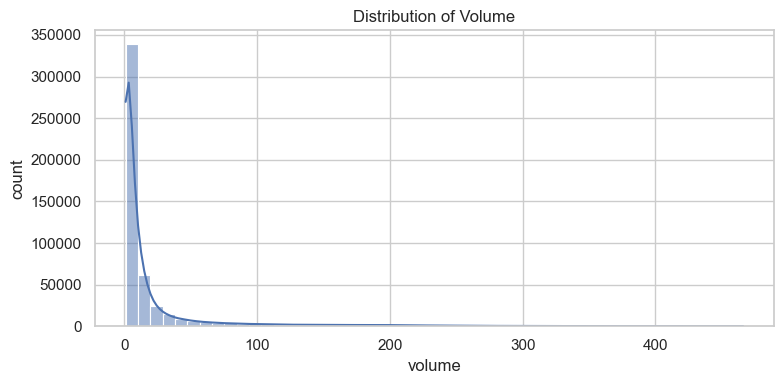

In [99]:
# 6a.1) Distribution of volume
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='volume', bins=50, kde=True)
plt.title('Distribution of Volume')
plt.xlabel('volume')
plt.ylabel('count')
plt.tight_layout()
plt.show()

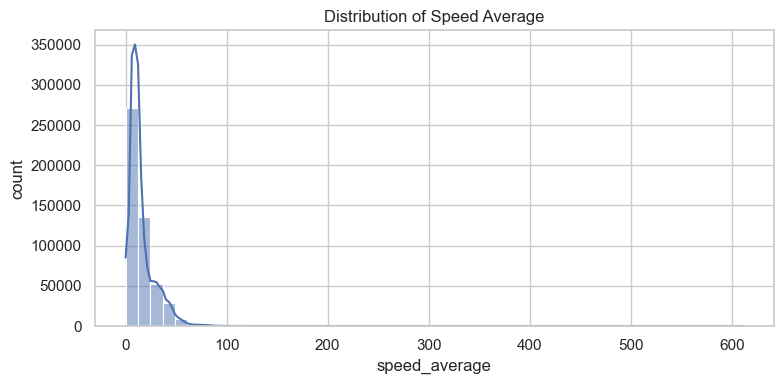

In [100]:
# 6a.2) Distribution of speed_average
import seaborn as sns
import matplotlib.pyplot as plt
if 'speed_average' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x='speed_average', bins=50, kde=True)
    plt.title('Distribution of Speed Average')
    plt.xlabel('speed_average')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

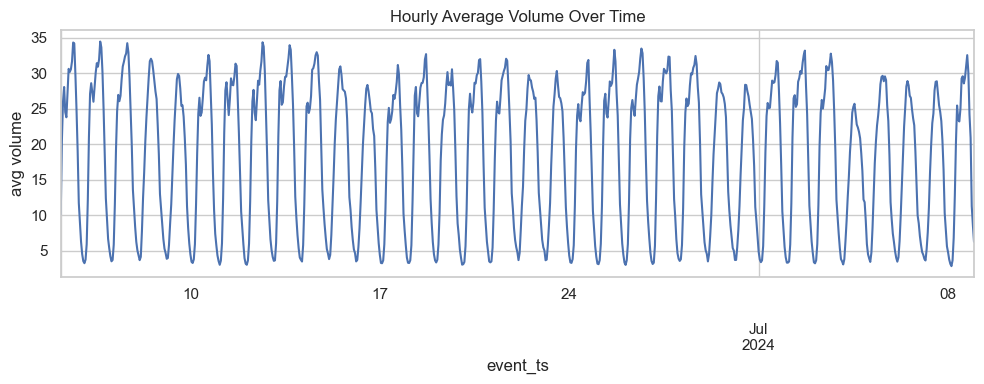

In [101]:
# Hourly average volume over time
ts_df = df.dropna(subset=['event_ts']).copy()
ts_df = ts_df.set_index('event_ts')
ts_hourly = ts_df['volume'].resample('H').mean()
plt.figure(figsize=(10,4))
ts_hourly.plot()
plt.title('Hourly Average Volume Over Time')
plt.ylabel('avg volume')
plt.tight_layout()
plt.show()

In [102]:
# 7) Deduplicate and sanity checks
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f'Deduplicated: {before - after} rows removed; final rows: {after}')
print('Nulls per column (top 10):')
display(df.isna().sum().sort_values(ascending=False).head(10))

Deduplicated: 0 rows removed; final rows: 500000
Nulls per column (top 10):


atd_device_id              0
bin_duration               0
heavy_vehicle              0
intersection_name          0
read_date                  0
record_id                  0
seconds_in_zone_average    0
seconds_in_zone_stddev     0
speed_average              0
volume                     0
dtype: int64

In [104]:
# 8) Convert to Kafka-friendly JSON Lines

# Choose key fields; common choices: record_id or combination of device + timestamp
key_field = 'record_id' if 'record_id' in df.columns else None

# Build minimal clean schema for Kafka (you can expand as needed)
keep_cols = [c for c in df.columns if c in [
    'record_id','atd_device_id','intersection_name','direction','movement',
    'heavy_vehicle','volume','speed_average','speed_stddev',
    'seconds_in_zone_average','seconds_in_zone_stddev','event_ts_iso'
 ] and c in df.columns]

clean_df = df[keep_cols].copy()
# Ensure we save under the repository root data/dataset, not notebooks/data/dataset
out_dir = ROOT / 'data' / 'dataset'
out_dir.mkdir(parents=True, exist_ok=True)
jsonl_path = out_dir / 'traffic_counts_kafka.jsonl'

# Write JSON Lines (one record per line) suitable for FileStream or producer scripts
with open(jsonl_path, 'w', encoding='utf-8') as f:
    for _, row in clean_df.iterrows():
        obj = row.to_dict()
        # Ensure booleans and numeric types are JSON-compatible
        for k, v in obj.items():
            if pd.isna(v):
                obj[k] = None
        # Optionally add Kafka key if present
        if key_field and key_field in obj:
            obj['kafka_key'] = str(obj[key_field])
        f.write(json.dumps(obj, ensure_ascii=False) + '\n')

print(f'Wrote Kafka-friendly JSONL: {jsonl_path.resolve()}')
print('Sample records:')
with open(jsonl_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line.strip())

Wrote Kafka-friendly JSONL: C:\Users\ASUS\Documents\real-time-camera-traffic-data-analytic\data\dataset\traffic_counts_kafka.jsonl
Sample records:
{"atd_device_id": 6653, "heavy_vehicle": true, "intersection_name": "38TH ST / MEDICAL PKWY", "record_id": "1f951a23cfcf1c29a5a524fb4af93ca9", "seconds_in_zone_average": 1.6, "seconds_in_zone_stddev": 0.0, "speed_average": 8.0, "volume": 1, "event_ts_iso": "2024-07-08T23:45:00", "kafka_key": "1f951a23cfcf1c29a5a524fb4af93ca9"}
{"atd_device_id": 6653, "heavy_vehicle": false, "intersection_name": "38TH ST / MEDICAL PKWY", "record_id": "235c1259a7f847b8d26b5e7e33820126", "seconds_in_zone_average": 8.619, "seconds_in_zone_stddev": 11.177, "speed_average": 23.381, "volume": 21, "event_ts_iso": "2024-07-08T23:45:00", "kafka_key": "235c1259a7f847b8d26b5e7e33820126"}
{"atd_device_id": 6653, "heavy_vehicle": true, "intersection_name": "38TH ST / MEDICAL PKWY", "record_id": "7d3f7d7771941f58c9dfb2e0b730ac48", "seconds_in_zone_average": 14.1, "seconds_